# Pointer Network - Convex Hull

This Jupyter Notebook outlines a solution to the planar convex hull problem by employing the pointer network architecture. We first generate a toy dataset consisting of 2D uniformly distributed points and convex hull indices by using `numpy`, `scipy`, and `shapely`. We then define a neural network architecture that generates input and target embeddings using a transformer encoder and decoder, respectively, followed by a pointer network to express a conditional probability over the input tokens. Lastly, we train the model and visualize a sample output.

For a high-level overview of this topic, refer to the Medium article [Pointer Networks with Transformers](https://medium.com/@masonmcgough/pointer-networks-with-transformers-1a01d83f7543).

In [1]:
import math
from pprint import pprint
from typing import Tuple, Union, Optional
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely import geometry

%matplotlib inline

In [2]:
def read_coordinates_from_file(file_path):
    coordinates = []
    with open(file_path, "r") as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:
                try:
                    x = float(parts[0])
                    y = float(parts[1])
                except(ValueError):
                    continue
                coordinates.append((x, y))
    return coordinates

file_path_test_50 = r"tsp_unif_test50_100_100000.txt"
file_path_train_50 = r"tsp_unif50_10000_100000_1000.txt"
file_path_test_100 = r"tsp_unif_test100_100_100000.txt"
file_path_train_100 = r"tsp_unif100_10000_100000_1000.txt"

coordinates_test50 = read_coordinates_from_file(file_path_test_50)
test50 = np.array(coordinates_test50)
coordinates_train50 = read_coordinates_from_file(file_path_train_50)
train50 = np.array(coordinates_train50)

coordinates_test100 = read_coordinates_from_file(file_path_test_100)
test100 = np.array(coordinates_test100)

coordinates_train100 = read_coordinates_from_file(file_path_train_100)
train100 = np.array(coordinates_train100)

print(test50.shape, train50.shape, test100.shape, train100.shape)

testinstances50 = []
for i in range(0, 5000, 50):
    testinstances50.append(test50[i:i+50, :])
testinstances50 = np.array(testinstances50)
optimal_distances_test50 = []
for i in range(testinstances50.shape[0]):
    distance = 0
    for j in range(testinstances50.shape[1]-1):
        distance += np.linalg.norm(testinstances50[i][j] -  testinstances50[i][j+1])
    optimal_distances_test50.append(distance)
optimal_distances_test50 = np.array(optimal_distances_test50)

traininstances50 = []
for i in range(0, 1500000, 50):
    traininstances50.append(train50[i:i+50, :])
traininstances50 = np.array(traininstances50)
optimal_distances_train50 = []
for i in range(traininstances50.shape[0]):
    distance = 0
    for j in range(traininstances50.shape[1]-1):
        distance += np.linalg.norm(traininstances50[i][j] -  traininstances50[i][j+1])
    optimal_distances_train50.append(distance)
optimal_distances_train50 = np.array(optimal_distances_train50)
testinstances100 = []
for i in range(0, 10000, 100):
    testinstances100.append(test100[i:i+100, :])
testinstances100 = np.array(testinstances100)
optimal_distances_test100 = []
for i in range(testinstances100.shape[0]):
    distance = 0
    for j in range(testinstances100.shape[1]-1):
        distance += np.linalg.norm(testinstances100[i][j] -  testinstances100[i][j+1])
    optimal_distances_test100.append(distance)
optimal_distances_test100 = np.array(optimal_distances_test100)

traininstances100 = []
for i in range(0, 1000000, 100):
    traininstances100.append(train100[i:i+100, :])
traininstances100 = np.array(traininstances100)
optimal_distances_train100 = []
for i in range(traininstances100.shape[0]):
    distance = 0
    for j in range(traininstances100.shape[1]-1):
        distance += np.linalg.norm(traininstances100[i][j] -  traininstances100[i][j+1])
    optimal_distances_train100.append(distance)
optimal_distances_train100 = np.array(optimal_distances_train100)

(5000, 2) (1500000, 2) (10000, 2) (1000000, 2)


In [3]:
# TOKENS = {
#   '<sos>': 0,
#   '<eos>': 1
# }
import random
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
temp1 = np.array(([0.0, 0.0])).reshape(1,2)
TOKENS = {
  '<eos>': 0
}
class TSPDataset50():
    def __init__(self):
        self.points = []
        self.targets = []
        for i in traininstances50:
            num_rows = i.shape[0]
            row_indices = np.arange(num_rows)
            np.random.shuffle(row_indices)
            shuffled_array = i[row_indices]
            inverse_indices = np.argsort(row_indices)
            self.points.append(scaler.fit_transform(shuffled_array))
            self.targets.append(inverse_indices)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        points, targets = torch.tensor(self.points[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.int64)
        length = torch.tensor(len(points), dtype=torch.int64)
        return points, targets, length

    def __len__(self) -> int:
        return len(self.points)
    
class TSPDatasetTest50():
    def __init__(self):
        self.max_samples = len(testinstances50)
        self.points = []
        self.targets = []
        for i in testinstances50:
            num_rows = i.shape[0]
            row_indices = np.arange(num_rows)
            np.random.shuffle(row_indices)
            shuffled_array = i[row_indices]
            inverse_indices = np.argsort(row_indices)
            self.points.append(scaler.fit_transform(shuffled_array))
            self.targets.append(inverse_indices)
            

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        points, targets = torch.tensor(self.points[idx],dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.int64)
        length = torch.tensor(len(points), dtype=torch.int64)
        return points, targets, length

    def __len__(self) -> int:
        return len(self.points)
    
class TSPDataset100():
    def __init__(self):
        self.max_samples = len(traininstances100)
        self.points = []
        self.targets = []
        for i in traininstances100:
            num_rows = i.shape[0]
            row_indices = np.arange(num_rows)
            np.random.shuffle(row_indices)
            shuffled_array = i[row_indices]
            inverse_indices = np.argsort(row_indices)
            self.points.append(scaler.fit_transform(shuffled_array))
            self.targets.append(inverse_indices)
            

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        points, targets = torch.tensor(self.points[idx],dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.int64)
        length = torch.tensor(len(points), dtype=torch.int64)
        return points, targets, length

    def __len__(self) -> int:
        return len(self.points)

class TSPDatasetTest100():
    def __init__(self):
        self.max_samples = len(testinstances100)
        self.points = []
        self.targets = []
        for i in testinstances100:
            num_rows = i.shape[0]
            row_indices = np.arange(num_rows)
            np.random.shuffle(row_indices)
            shuffled_array = i[row_indices]
            inverse_indices = np.argsort(row_indices)
            self.points.append(scaler.fit_transform(shuffled_array))
            self.targets.append(inverse_indices)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        points, targets = torch.tensor(self.points[idx],dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.int64)
        length = torch.tensor(len(points), dtype=torch.int64)
        return points, targets, length

    def __len__(self) -> int:
        return len(self.points)

In [4]:
print(np.mean(optimal_distances_test50))

554860.3674863264


# Pointer Network Architecture

Here we define a series of functions that we will need to construct our architecture.

This is where we define the pointer network.

In [5]:
def info_value_of_dtype(dtype: torch.dtype):
  """
  Returns the `finfo` or `iinfo` object of a given PyTorch data type. Does not allow torch.bool.

  Adapted from allennlp by allenai:
    https://github.com/allenai/allennlp/blob/master/allennlp/nn/util.py
  """

  if dtype == torch.bool:
    raise TypeError("Does not support torch.bool")
  elif dtype.is_floating_point:
    return torch.finfo(dtype)
  else:
    return torch.iinfo(dtype)


def min_value_of_dtype(dtype: torch.dtype):
  """
  Returns the minimum value of a given PyTorch data type. Does not allow torch.bool.

  Adapted from allennlp by allenai:
    https://github.com/allenai/allennlp/blob/master/allennlp/nn/util.py
  """

  return info_value_of_dtype(dtype).min

def masked_log_softmax(
  x: torch.Tensor,
  mask: torch.Tensor,
  dim: int = -1,
  eps: float = 1e-45
) -> torch.Tensor:
  """
  Apply softmax to x with masking.

  Adapted from allennlp by allenai:
    https://github.com/allenai/allennlp/blob/master/allennlp/nn/util.py

  Args:
    x - Tensor of arbitrary shape to apply softmax over.
    mask - Binary mask of same shape as x where "False" indicates elements
      to disregard from operation.
    dim - Dimension over which to apply operation.
    eps - Stability constant for log operation. Added to mask to avoid NaN
      values in log.
  Outputs:
    Tensor with same dimensions as x.
  """

  x = x + (mask.float() + eps).log()
  return torch.nn.functional.log_softmax(x, dim=dim)

def masked_max(
  x: torch.Tensor,
	mask: torch.Tensor,
	dim: int,
	keepdim: bool = False
) -> Tuple[torch.Tensor, torch.Tensor]:
  """
  Apply max to x with masking.

  Adapted from allennlp by allenai:
    https://github.com/allenai/allennlp/blob/master/allennlp/nn/util.py

  Args:
    x - Tensor of arbitrary shape to apply max over.
    mask - Binary mask of same shape as x where "False" indicates elements
      to disregard from operation.
    dim - Dimension over which to apply operation.
    keepdim - If True, keeps dimension dim after operation.
  Outputs:
    A ``torch.Tensor`` of including the maximum values.
  """

  x_replaced = x.masked_fill(~mask, min_value_of_dtype(x.dtype))
  max_value, max_index = x_replaced.max(dim=dim, keepdim=keepdim)
  return max_value, max_index

def convert_binary_mask_to_infinity_mask(mask: torch.Tensor) -> torch.Tensor:
  """
  Convert the 0 and 1 elements in a binary mask to -inf and 0 for the
    transformer.

  Args:
    mask: Binary mask tensor.
  Outputs:
    Infinity mask tensor with same size as mask.
  """

  return mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

In [6]:
class PointerNetwork(nn.Module):
  """
  From "Pointer Networks" by Vinyals et al. (2017)

  Adapted from pointer-networks-pytorch by ast0414:
    https://github.com/ast0414/pointer-networks-pytorch

  Args:
    n_hidden: The number of features to expect in the inputs.
  """

  def __init__(
    self,
    n_hidden: int
  ):
    super().__init__()
    self.n_hidden = n_hidden
    self.w1 = nn.Linear(n_hidden, n_hidden, bias=False)
    self.w2 = nn.Linear(n_hidden, n_hidden, bias=False)
    self.v = nn.Linear(n_hidden, 1, bias=False)

  def forward(
    self,
    x_decoder: torch.Tensor,
    x_encoder: torch.Tensor,
    mask: torch.Tensor,
    eps: float = 1e-16
  ) -> torch.Tensor:
    """
    Args:
      x_decoder: Encoding over the output tokens.
      x_encoder: Encoding over the input tokens.
      mask: Binary mask over the softmax input.
    Shape:
      x_decoder: (B, Ne, C)
      x_encoder: (B, Nd, C)
      mask: (B, Nd, Ne)
    """

    # (B, Nd, Ne, C) <- (B, Ne, C)
    encoder_transform = self.w1(x_encoder).unsqueeze(1).expand(
      -1, x_decoder.shape[1], -1, -1)
    # (B, Nd, 1, C) <- (B, Nd, C)
    decoder_transform = self.w2(x_decoder).unsqueeze(2)
    # (B, Nd, Ne) <- (B, Nd, Ne, C), (B, Nd, 1, C)
    prod = self.v(torch.tanh(encoder_transform + decoder_transform)).squeeze(-1)
    # (B, Nd, Ne) <- (B, Nd, Ne)
    log_score = masked_log_softmax(prod, mask, dim=-1, eps=eps)
    return log_score


In [7]:
class PositionalEncoding(nn.Module):
    """Positional Encoding Layer.
    Based on: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Explaination: https://medium.com/@a.arun283/a-deeper-look-into-the-positional-encoding-method-in-transformer-architectures-7e98f32a925f
    """

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000) -> None:
        """
        Initialize Positional Encoding Layer.

        Args:
            d_model (int): Hidden dimension of the model
            dropout (float, optional): Optional dropout of layer. Defaults to 0.1.
            max_len (int, optional): Max. length of the PE. Defaults to 5000.
        """
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the Positional Encoding Layer.

        Args:
            x (torch.Tensor): Input (seq_len, batch_size, embedding_dim)

        Returns:
            torch.Tensor: Output (seq_len, batch_size, embedding_dim)
        """
        x = x.to(device) + self.pe[:x.size(0)].to(device)
        return self.dropout(x)

We now put all of those pieces together to create `ConvexNet`, our PyTorch module for modeling our planar convex hull data.

In [8]:
class ConvexNet(nn.Module):
  def __init__(
    self,
    c_inputs: int = 5,
    c_embed: int = 8,
    n_heads: int = 2,
    n_layers: int = 1,
    dropout: float = 0.1,
    c_hidden: int = 2
  ):
    super().__init__()
    self.c_hidden = c_hidden
    self.c_inputs = c_inputs
    self.c_embed = c_embed
    self.n_heads = n_heads
    self.n_layers = n_layers
    self.dropout = dropout

    self.embedding = nn.Linear(c_inputs, c_embed, bias=False)
    encoder_layers = nn.TransformerEncoderLayer(c_embed, n_heads, c_hidden, dropout)
    self.encoder = nn.TransformerEncoder(encoder_layers, n_layers)
    decoder_layers = nn.TransformerDecoderLayer(c_embed, n_heads, c_hidden, dropout)
    self.decoder = nn.TransformerDecoder(decoder_layers, n_layers)
    self.pointer = PointerNetwork(n_hidden=c_embed)
    self.pos_encoder = PositionalEncoding(self.c_hidden)

  def forward(
    self,
    batch_data: torch.Tensor,
    batch_lengths: torch.Tensor,
    training = True,
    batch_labels: Optional[torch.Tensor] = None
  ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    # assumes batch-first inputs
    batch_size = batch_data.shape[0]
    max_seq_len = batch_data.shape[1]
    c_embed = self.c_embed
    n_heads = self.n_heads

    x_embed = self.embedding(batch_data)
    encoder_outputs = self.encoder(x_embed.permute(1, 0, 2))

    # make mask
    range_tensor = torch.arange(max_seq_len, device=batch_lengths.device,
      dtype=batch_lengths.dtype).expand(batch_size, max_seq_len - len(TOKENS), max_seq_len)
    each_len_tensor = batch_lengths.view(-1, 1, 1).expand(-1, max_seq_len - len(TOKENS), max_seq_len)
    mask_tensor = (range_tensor < each_len_tensor)
    mask_tensor[:, :, 0] = False

    if training:
      # teacher forcing
      # pass through decoder
      # here memory_mask is (batch_size * n_heads, len_decoder_seq, len_encoder_seq)
      # https://discuss.pytorch.org/t/memory-mask-in-nn-transformer/55230/5
      _bl = batch_labels[:, :-1].permute(1, 0).unsqueeze(-1)
      _bl = _bl.expand(-1, batch_size, c_embed)
      decoder_input = torch.gather(encoder_outputs, dim=0, index=_bl)
      decoder_mask = mask_tensor.repeat((n_heads, 1, 1))
      dm = convert_binary_mask_to_infinity_mask(decoder_mask)
      tgt_mask = nn.Transformer.generate_square_subsequent_mask(len(decoder_input)).to(dm.device)
      #positional encoding
      decoder_input = self.pos_encoder.forward(decoder_input.to("cuda"))
      decoder_outputs = self.decoder(decoder_input, encoder_outputs,
        tgt_mask=tgt_mask, memory_mask=dm)

      # pass through pointer network
      log_pointer_scores = self.pointer(
        decoder_outputs.permute(1, 0, 2),
        encoder_outputs.permute(1, 0, 2),
        mask_tensor)
      _, masked_argmaxs = masked_max(log_pointer_scores, mask_tensor, dim=-1)
      return log_pointer_scores, masked_argmaxs
    else:
      #
      log_pointer_scores = []
      masked_argmaxs = []
      _bl = batch_labels[:, :1].permute(1, 0).unsqueeze(-1)
      _bl = _bl.expand(-1, batch_size, c_embed)
      decoder_input = torch.gather(encoder_outputs, dim=0, index=_bl)
      for _ in range(max_seq_len - len(TOKENS)):
        # pass through decoder network
        decoder_mask = mask_tensor[:, :len(decoder_input)].repeat((n_heads, 1, 1))
        dm = convert_binary_mask_to_infinity_mask(decoder_mask)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(len(decoder_input)).to(dm.device)
        ##positional encoding
        decoder_input = self.pos_encoder.forward(decoder_input.to("cuda"))
        decoder_outputs = self.decoder(decoder_input, encoder_outputs,
          tgt_mask=tgt_mask, memory_mask=dm)
        
        # pass through pointer network
        mask_subset = mask_tensor[:, :len(decoder_outputs)]
        log_pointer_score = self.pointer(
          decoder_outputs.permute(1, 0, 2),
          encoder_outputs.permute(1, 0, 2),
          mask_subset)
        _, masked_argmax = masked_max(log_pointer_score, mask_subset, dim=-1)
    
        # append new predictions
        log_pointer_scores.append(log_pointer_score[:, -1, :])
        new_maxes = masked_argmax[:, -1]
        masked_argmaxs.append(new_maxes)
        #print(new_maxes)
        
        # mask out predicted inputs
        new_max_mask = torch.zeros((mask_tensor.shape[0], mask_tensor.shape[2]),
          dtype=torch.bool, device=mask_tensor.device)
        new_max_mask = new_max_mask.scatter(1, new_maxes.unsqueeze(1), True)
        #new_max_mask[:, :2] = False
        new_max_mask = new_max_mask.unsqueeze(1).expand(-1, mask_tensor.shape[1], -1)
        #print(mask_tensor, new_max_mask)
        mask_tensor[new_max_mask] = False

        # prepare inputs for next iteration
        next_indices = torch.stack(masked_argmaxs, dim=0).unsqueeze(-1).expand(-1, batch_size, c_embed)
        decoder_input = torch.cat((encoder_outputs[:1],
          torch.gather(encoder_outputs, dim=0, index=next_indices)), dim=0)
      
      log_pointer_scores = torch.stack(log_pointer_scores, dim=1)
      masked_argmaxs = torch.stack(masked_argmaxs, dim=1)
    
      return log_pointer_scores, masked_argmaxs

# Train

Now we prepare for training. We first construct a class to calculate and track the averages for an epoch.

In [9]:
class AverageMeter(object):
  """
  Computes and stores the average and current value

  Adapted from pointer-networks-pytorch by ast0414:
    https://github.com/ast0414/pointer-networks-pytorch
  """

  def __init__(self):
    self.history = []
    self.reset(record=False)

  def reset(
    self,
    record: bool = True
  ):
    if record:
      self.history.append(self.avg)
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(
    self,
    val: Union[float, int],
    n: int = 1
  ):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def masked_accuracy(
  output: torch.Tensor,
  target: torch.Tensor,
  mask: torch.Tensor
) -> float:
  """
  Compute accuracy of softmax output with mask applied over values.

  Adapted from pointer-networks-pytorch by ast0414:
    https://github.com/ast0414/pointer-networks-pytorch
  """

  with torch.no_grad():
    masked_output = torch.masked_select(output, mask)
    masked_target = torch.masked_select(target, mask)
    accuracy = masked_output.eq(masked_target).float().mean()
    return accuracy

def calculate_opt_dist(data, length):
    distance = 0
    for i in range(length-1):
        distance += np.linalg.norm(data[i] -  data[i+1])
    return distance

We generate a set of training and validation datasets to use for training.

In [10]:
train = TSPDataset50()
val = TSPDatasetTest50()

In [11]:
#print(testinstances50[0], val.__getitem__(0))

With these put in place, we create and train a model. Feel free to modify the arguments below to see how they affect the performance and accuracy.

In [12]:
torch.cuda.empty_cache()

c_inputs = 2
c_embed = 16
c_hidden = 16
n_heads = 4
n_layers = 3
dropout = 0.0
use_cuda = True
n_workers = 2

n_epochs = 10

batch_size = 16
lr = 1e-3
log_interval = 500

device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")

train_loader = DataLoader(train, batch_size=batch_size,
  num_workers=n_workers, shuffle = True)
val_loader = DataLoader(val, batch_size=batch_size,
  num_workers=n_workers)

model = ConvexNet(c_inputs=c_inputs, c_embed=c_embed, n_heads=n_heads,
  n_layers=n_layers, dropout=dropout, c_hidden=c_hidden).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.NLLLoss(ignore_index=TOKENS['<eos>'])

train_loss = AverageMeter()
train_accuracy = AverageMeter()
val_loss = AverageMeter()
val_accuracy = AverageMeter()

# begin training
for epoch in range(n_epochs):
  model.train()
  for bat, (batch_data, batch_labels, batch_lengths) in enumerate(train_loader):
    batch_data = batch_data.to(device)
    batch_labels = batch_labels.to(device)
    batch_lengths = batch_lengths.to(device)

    optimizer.zero_grad()
    #print(batch_data.shape, batch_labels.shape, batch_lengths)
    log_pointer_scores, pointer_argmaxs = model(batch_data, batch_lengths, batch_labels=batch_labels)
    #print(log_pointer_scores.shape, pointer_argmaxs.shape)
    loss = criterion(log_pointer_scores.view(-1, log_pointer_scores.shape[-1]), batch_labels[:, 1:].reshape(-1))
    assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'

    loss.backward()
    optimizer.step()

    train_loss.update(loss.item(), batch_data.size(0))
    mask = batch_labels[:, 1:] != TOKENS['<eos>']
    acc = masked_accuracy(pointer_argmaxs, batch_labels[:, 1:], mask).item()
    train_accuracy.update(acc, mask.int().sum().item())

    if bat % log_interval == 0:
      print(f'Epoch {epoch}: '
            f'Train [{bat * len(batch_data):9d}/{len(train):9d} '
            f'Loss: {train_loss.avg:.6f}\tAccuracy: {train_accuracy.avg:3.4%}')
    
  model.eval()
  opt_dists = []
  for bat, (batch_data, batch_labels, batch_lengths) in enumerate(val_loader):
    batch_data = batch_data.to(device)
    batch_labels = batch_labels.to(device)
    batch_lengths = batch_lengths.to(device)
    
    log_pointer_scores, pointer_argmaxs = model(batch_data, batch_lengths, batch_labels=batch_labels, training = False)
    
    loss = criterion(log_pointer_scores.view(-1, log_pointer_scores.shape[-1]), batch_labels[:, 1:].reshape(-1))
    assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'

    val_loss.update(loss.item(), batch_data.size(0))
    mask = batch_labels[:, 1:] != TOKENS['<eos>']
    acc = masked_accuracy(pointer_argmaxs, batch_labels[:, 1:], mask).item()
    val_accuracy.update(acc, mask.int().sum().item())

    for data, length, ptr in zip(batch_data.cpu(), batch_lengths.cpu(),
        pointer_argmaxs.cpu()):
      #print(ptr)
      opt_dists.append(calculate_opt_dist(ptr, len(ptr)))

  print(f'Epoch {epoch}: Val\Loss: {val_loss.avg:.6f} '
        f'\tAccuracy: {val_accuracy.avg:3.4%} '
        f'\tPredicted_Optimal_Distance: {np.mean(opt_dists):3.4%}')
        #f'\tOptimal_Distance: {np.mean(opt_dists):3.4%}')
  train_loss.reset()
  train_accuracy.reset()
  val_loss.reset()
  val_accuracy.reset()

Epoch 0: Train [        0/    30000 Loss: 3.899199	Accuracy: 2.2107%
Epoch 0: Train [     8000/    30000 Loss: 2.651919	Accuracy: 16.1287%
Epoch 0: Train [    16000/    30000 Loss: 2.266815	Accuracy: 21.5060%
Epoch 0: Train [    24000/    30000 Loss: 2.098786	Accuracy: 24.5910%
Epoch 0: Val\Loss: 23.261776 	Accuracy: 2.8750% 	Predicted_Optimal_Distance: 80498.0000%
Epoch 1: Train [        0/    30000 Loss: 1.700327	Accuracy: 33.1599%
Epoch 1: Train [     8000/    30000 Loss: 1.660402	Accuracy: 35.3527%
Epoch 1: Train [    16000/    30000 Loss: 1.640388	Accuracy: 36.2678%
Epoch 1: Train [    24000/    30000 Loss: 1.621760	Accuracy: 37.1118%
Epoch 1: Val\Loss: 24.350044 	Accuracy: 4.3750% 	Predicted_Optimal_Distance: 80997.0000%
Epoch 2: Train [        0/    30000 Loss: 1.619465	Accuracy: 38.4115%
Epoch 2: Train [     8000/    30000 Loss: 1.527490	Accuracy: 41.4834%
Epoch 2: Train [    16000/    30000 Loss: 1.511264	Accuracy: 42.2365%
Epoch 2: Train [    24000/    30000 Loss: 1.496148	Ac

In [13]:
torch.cuda.empty_cache()

c_inputs = 2
c_embed = 16
c_hidden = 16
n_heads = 4
n_layers = 3
dropout = 0.0
use_cuda = True
n_workers = 2

n_epochs = 10

batch_size = 16
lr = 1e-3
log_interval = 500

device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")

train_loader = DataLoader(train, batch_size=batch_size,
  num_workers=n_workers)
val_loader = DataLoader(val, batch_size=batch_size,
  num_workers=n_workers)

model = ConvexNet(c_inputs=c_inputs, c_embed=c_embed, n_heads=n_heads,
  n_layers=n_layers, dropout=dropout, c_hidden=c_hidden).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.NLLLoss(ignore_index=TOKENS['<eos>'])

train_loss = AverageMeter()
train_accuracy = AverageMeter()
val_loss = AverageMeter()
val_accuracy = AverageMeter()

# begin training
for epoch in range(n_epochs):
  model.train()
  for bat, (batch_data, batch_labels, batch_lengths) in enumerate(train_loader):
    batch_data = batch_data.to(device)
    batch_labels = batch_labels.to(device)
    batch_lengths = batch_lengths.to(device)

    optimizer.zero_grad()
    #print(batch_data.shape, batch_labels.shape, batch_lengths)
    log_pointer_scores, pointer_argmaxs = model(batch_data, batch_lengths, batch_labels=batch_labels)
    #print(log_pointer_scores.shape, pointer_argmaxs.shape)
    loss = criterion(log_pointer_scores.view(-1, log_pointer_scores.shape[-1]), batch_labels[:, 1:].reshape(-1))
    assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'

    loss.backward()
    optimizer.step()

    train_loss.update(loss.item(), batch_data.size(0))
    mask = batch_labels[:, 1:] != TOKENS['<eos>']
    acc = masked_accuracy(pointer_argmaxs, batch_labels[:, 1:], mask).item()
    train_accuracy.update(acc, mask.int().sum().item())

    if bat % log_interval == 0:
      print(f'Epoch {epoch}: '
            f'Train [{bat * len(batch_data):9d}/{len(train):9d} '
            f'Loss: {train_loss.avg:.6f}\tAccuracy: {train_accuracy.avg:3.4%}')
    
  model.eval()
  opt_dists = []
  for bat, (batch_data, batch_labels, batch_lengths) in enumerate(val_loader):
    batch_data = batch_data.to(device)
    batch_labels = batch_labels.to(device)
    batch_lengths = batch_lengths.to(device)

    log_pointer_scores, pointer_argmaxs = model(batch_data, batch_lengths,  batch_labels=batch_labels, training = False)
    
    loss = criterion(log_pointer_scores.view(-1, log_pointer_scores.shape[-1]), batch_labels[:, 1:].reshape(-1))
    assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'

    val_loss.update(loss.item(), batch_data.size(0))
    mask = batch_labels[:, 1:] != TOKENS['<eos>']
    acc = masked_accuracy(pointer_argmaxs, batch_labels[:, 1:], mask).item()
    val_accuracy.update(acc, mask.int().sum().item())

    for data, length, ptr in zip(batch_data.cpu(), batch_lengths.cpu(),
        pointer_argmaxs.cpu()):
      opt_dists.append(calculate_opt_dist(ptr, len(ptr)))

  print(f'Epoch {epoch}: Val\Loss: {val_loss.avg:.6f} '
        f'\tAccuracy: {val_accuracy.avg:3.4%} '
        f'\tPredicted_Optimal_Distance: {np.mean(opt_dists):3.4%}')
        #f'\tOptimal_Distance: {np.mean(opt_dists):3.4%}')
  train_loss.reset()
  train_accuracy.reset()
  val_loss.reset()
  val_accuracy.reset()

Epoch 0: Train [        0/    10000 Loss: 4.596367	Accuracy: 1.0204%
Epoch 0: Train [     8000/    10000 Loss: 3.113393	Accuracy: 12.5469%
Epoch 0: Val\Loss: 23.842910 	Accuracy: 1.6529% 	Predicted_Optimal_Distance: 325146.0000%
Epoch 1: Train [        0/    10000 Loss: 2.333724	Accuracy: 15.4974%
Epoch 1: Train [     8000/    10000 Loss: 2.125074	Accuracy: 20.0933%
Epoch 1: Val\Loss: 23.907783 	Accuracy: 2.2345% 	Predicted_Optimal_Distance: 325852.0000%
Epoch 2: Train [        0/    10000 Loss: 2.026098	Accuracy: 22.9592%
Epoch 2: Train [     8000/    10000 Loss: 2.003520	Accuracy: 22.2419%
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.0.1/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4063046/2531760084.py", line 52, in <module>
    optimizer.step()
  File "/apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.0.1/lib/python3.11/site-packages/torch/optim/optimizer.py", line 280, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.0.1/lib/python3.11/site-packages/torch/optim/optimizer.py", line 33, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.0.1/lib/python3.11/site-packages/torch/optim/adam.py", line 141, in step
    adam(
  File "/apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.0.1/lib/python3.11/site-packages/torch/optim/adam.py", line 281, in ad

Best Scores:
train_loss: 0.9196 (ep: 99)
train_accuracy 69.38% (ep: 99)
val_loss: 13.7374 (ep: 0)
val_accuracy: 1.21% (ep: 26)


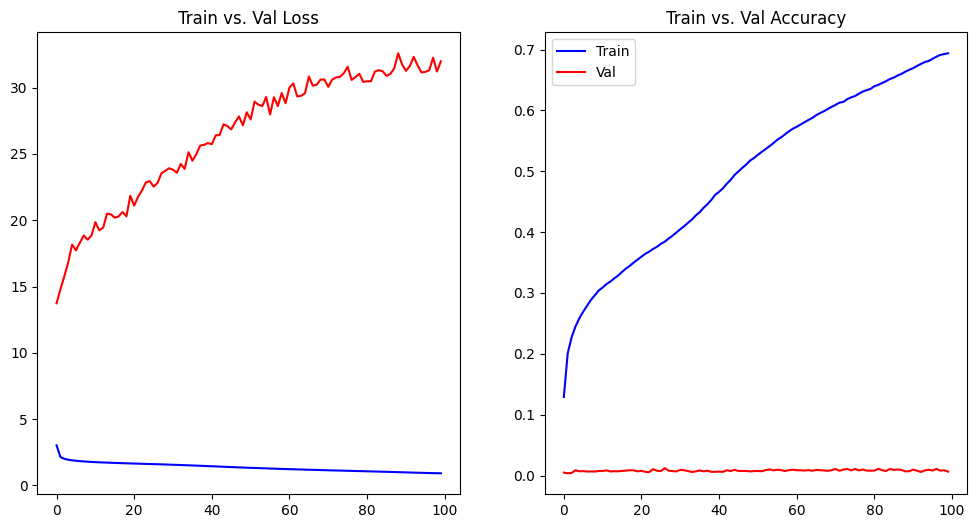

In [12]:
# display metrics and curves
idx_best_train_loss = np.argmin(train_loss.history)
best_train_loss = train_loss.history[idx_best_train_loss]
idx_best_train_accuracy = np.argmax(train_accuracy.history)
best_train_accuracy = train_accuracy.history[idx_best_train_accuracy]
idx_best_val_loss = np.argmin(val_loss.history)
best_val_loss = val_loss.history[idx_best_val_loss]
idx_best_val_accuracy = np.argmax(val_accuracy.history)
best_val_accuracy = val_accuracy.history[idx_best_val_accuracy]
print('Best Scores:')
print(f'train_loss: {best_train_loss:.4f} (ep: {idx_best_train_loss})')
print(f'train_accuracy {best_train_accuracy:3.2%} (ep: {idx_best_train_accuracy})')
print(f'val_loss: {best_val_loss:.4f} (ep: {idx_best_val_loss})')
print(f'val_accuracy: {best_val_accuracy:3.2%} (ep: {idx_best_val_accuracy})')

x_epochs = list(range(n_epochs))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(x_epochs, train_loss.history, 'b')
ax[0].plot(x_epochs, val_loss.history, 'r')
_ = ax[0].set_title('Train vs. Val Loss')
ax[1].plot(x_epochs, train_accuracy.history, 'b', label='Train')
ax[1].plot(x_epochs, val_accuracy.history, 'r', label='Val')
_ = ax[1].set_title('Train vs. Val Accuracy')
ax[1].legend()